In [2]:
from keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
from keras import models
import tensorflow as tf

/Users/lucasremigio/Developer/SSC/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
import os

# Caminho local para a pasta raiz do projeto
root_path = "./"  

# Listar diretórios no caminho raiz
print("📁 Diretórios no caminho raiz:")
print(os.listdir(root_path))

# Verificar conteúdo de um caminho específico
specific_path = os.path.join(root_path, "garbage-noaug-70-15-15")
if os.path.exists(specific_path):
    print(f"\n📁 Conteúdo de {specific_path}:")
    print(os.listdir(specific_path))
else:
    print(f"\n❌ Caminho {specific_path} não existe")

# Função para listar diretórios com profundidade
def list_dirs(path, indent=0):
    for item in os.listdir(path):
        full_path = os.path.join(path, item)
        if os.path.isdir(full_path):
            print(" " * indent + "📁 " + item)
            if indent < 4:
                list_dirs(full_path, indent + 2)
        else:
            print(" " * indent + "📄 " + item)

# Explorar estrutura de diretórios
print("\n📂 Estrutura de diretórios:")
list_dirs(root_path, 0)

📁 Diretórios no caminho raiz:
['garbage-dataset-aug-87-6-6', '.DS_Store', 'requirements.txt', 'SSC_2_final_optimized.ipynb', 'garbage-dataset', 'SSC_3_modelo_LeakyReLU.ipynb', 'garbage-noaug-70-15-15', 'models', '.gitignore', '.venv', 'ssc.py', '.git', 'SSC.ipynb', 'SSC_4.ipynb']

📁 Conteúdo de ./garbage-noaug-70-15-15:
['README.roboflow.txt', 'valid', 'README.dataset.txt', '.DS_Store', 'test', 'train']

📂 Estrutura de diretórios:
📁 garbage-dataset-aug-87-6-6
  📄 README.roboflow.txt
  📁 valid
    📁 paper
    📁 clothes
    📁 metal
    📁 cardboard
    📁 trash
    📁 glass
    📁 biological
    📁 battery
    📁 plastic
    📁 shoes
  📄 README.dataset.txt
  📁 test
    📁 paper
    📁 clothes
    📁 metal
    📁 cardboard
    📁 trash
    📁 glass
    📁 biological
    📁 battery
    📁 plastic
    📁 shoes
  📁 train
    📁 paper
    📁 clothes
    📁 metal
    📁 cardboard
    📁 trash
    📁 glass
    📁 biological
    📁 battery
    📁 plastic
    📁 shoes
📄 .DS_Store
📄 requirements.txt
📄 SSC_2_final_optimized.

In [5]:
# Improved Metal GPU detection for Apple Silicon
try:
    # First try looking for GPU devices (newer TF versions label Metal as GPU)
    gpus = tf.config.list_physical_devices('GPU')
    if len(gpus) > 0:
        print(f"Found {len(gpus)} GPU device(s)")
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU acceleration enabled (Metal)")
    # If no GPU found, try looking specifically for MPS devices
    elif hasattr(tf.config, 'list_physical_devices') and len(tf.config.list_physical_devices('MPS')) > 0:
        mps_devices = tf.config.list_physical_devices('MPS')
        tf.config.experimental.set_visible_devices(mps_devices[0], 'MPS')
        print("MPS (Metal) device enabled")
    else:
        print("No GPU or MPS device found, using CPU")
        
    # Verify what device is being used
    print("\nDevice being used:", tf.config.get_visible_devices())
    
    # Test with a simple operation to confirm GPU usage
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
        b = tf.constant([[5.0, 6.0], [7.0, 8.0]])
        c = tf.matmul(a, b)
        print("Matrix multiplication result:", c)
        print("GPU test successful!")
except Exception as e:
    print(f"Error setting up GPU: {e}")
    print("Falling back to CPU")

Found 1 GPU device(s)
GPU acceleration enabled (Metal)

Device being used: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Matrix multiplication result: tf.Tensor(
[[19. 22.]
 [43. 50.]], shape=(2, 2), dtype=float32)
GPU test successful!


In [6]:
# Enable mixed precision (faster on GPU)
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')  # Use FP16 instead of FP32

In [7]:
train_dir = specific_path + "/train"
validation_dir = specific_path + "/valid"
test_dir = specific_path + "/test"

# Images are 640, but 224 is way faster for training
IMG_SIZE = 160
BATCH_SIZE = 64


train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

validation_dataset = image_dataset_from_directory(
    validation_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

train_dataset_pref = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset_pref = validation_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset_pref = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 13833 files belonging to 10 classes.
Found 2965 files belonging to 10 classes.
Found 2964 files belonging to 10 classes.


In [8]:
# Add this code to check class balance
import pandas as pd

class_counts = {}
for _, labels in train_dataset:
    for label in labels.numpy():
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

df = pd.DataFrame({'class': train_dataset.class_names, 'count': [class_counts.get(i, 0) for i in range(len(train_dataset.class_names))]})
print(df)

        class  count
0     battery    666
1  biological    690
2   cardboard   1297
3     clothes   3730
4       glass   2093
5       metal    708
6       paper   1184
7     plastic   1382
8       shoes   1410
9       trash    673


2025-06-02 18:34:12.874333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
# Simpler CNN architecture for faster training
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1./255)(inputs)

# Reduced number of filters and layers for faster training
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)

# Simplified dense layers
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)  # Reduced dropout
x = layers.Dense(256, activation='relu')(x)  # Smaller dense layer
outputs = layers.Dense(len(train_dataset.class_names), activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

# Use a simpler optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Compile with better optimizer
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary to see the reduction in parameters
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,203,274 (50.37 MB)

 Trainable params: 13,203,274 (50.37 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Add to your training cell
import time

class TimeoutCallback(tf.keras.callbacks.Callback):
    def __init__(self, max_time_mins=2):
        super().__init__()
        self.max_time_sec = max_time_mins * 60
        self.start_time = time.time()
        
    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.start_time
        if elapsed > self.max_time_sec:
            print(f"\nReached time limit ({self.max_time_sec/3600:.1f}h). Stopping training.")
            self.model.stop_training = True

# Maximum 20 minutes of training to prevent overheating
timeout_cb = TimeoutCallback(max_time_mins=20)


In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=5,
    restore_best_weights=True
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "models/model_checkpoint.keras", 
    save_best_only=True,
    monitor="val_accuracy"
)

# Add more callbacks for better training
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Calculate class weights
total = sum(class_counts.values())
class_weight = {i: total/count for i, count in class_counts.items()}


In [12]:
import psutil
import subprocess
import platform

class ResourceMonitorCallback(tf.keras.callbacks.Callback):
    def __init__(self, check_interval=1):
        super().__init__()
        self.check_interval = check_interval
        self.epoch_count = 0
        self.is_mac = platform.system() == 'Darwin'
        
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_count += 1
        if self.epoch_count % self.check_interval == 0:
            # Get basic info
            cpu_percent = psutil.cpu_percent(interval=0.5)
            memory = psutil.virtual_memory()
            mem_used = f"{memory.percent}% ({memory.used / 1024**3:.1f}GB)"
            
            # Temperature check - simplified
            temp = "N/A"
            if self.is_mac:
                try:
                    # Try thermal level from pmset (no sudo needed)
                    result = subprocess.run(['pmset', '-g', 'therm'], capture_output=True, text=True)
                    if "CPU_Thermal_level" in result.stdout:
                        temp = result.stdout.strip()
                except: pass
            
            # Simplified output
            print(f"\n[Epoch {epoch}] CPU: {cpu_percent}% | Memory: {mem_used}")
            print(f"Thermal: {temp}")
            print(f"GPU: {'Active' if self.is_mac else 'Unknown'}")

# Create monitor that checks every epoch
resource_monitor = ResourceMonitorCallback(check_interval=1)

In [ ]:
# TRAINN!!!!
history = model.fit(
    train_dataset_pref,
    validation_data=validation_dataset_pref,
    epochs=20,
    class_weight=class_weight, 
    callbacks=[early_stopping, reduce_lr, checkpoint_cb, timeout_cb, resource_monitor]
)

# Save the entire model (architecture + weights + optimizer state)
model.save("models/garbage_classifier_model.keras")  
print("Model saved successfully!")

Epoch 1/20


2025-06-02 18:35:10.105586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


 60/217 ━━━━━━━━━━━━━━━━━━━━ 17s 111ms/step - accuracy: 0.1017 - loss: 59.3284

KeyboardInterrupt: 

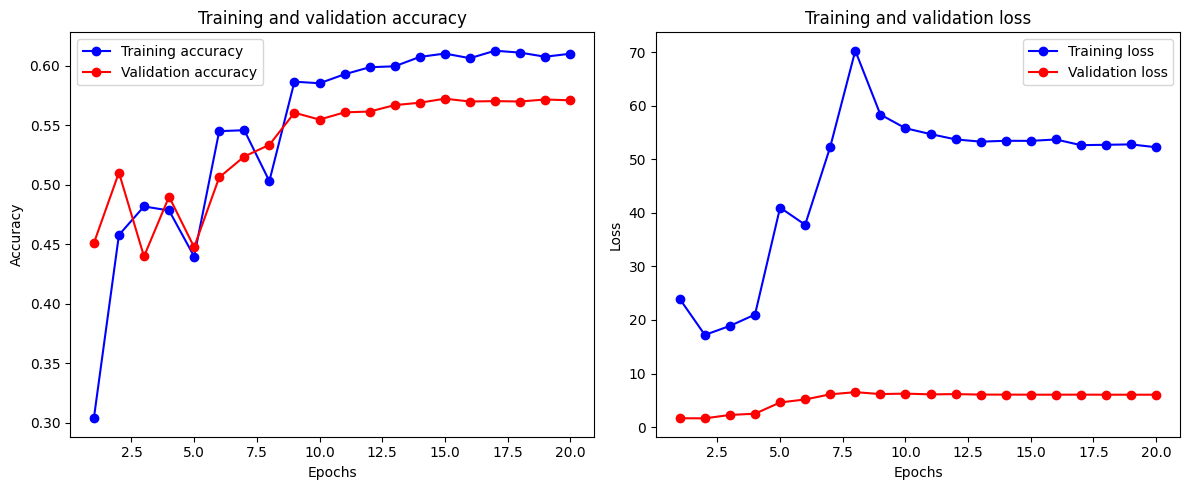

In [91]:
# Corrected plotting code for newer TensorFlow versions
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5693 - loss: 6.0152
Test accuracy: 0.5648
Test loss: 6.0262
Classes: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2025-05-31 17:02:14.275485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


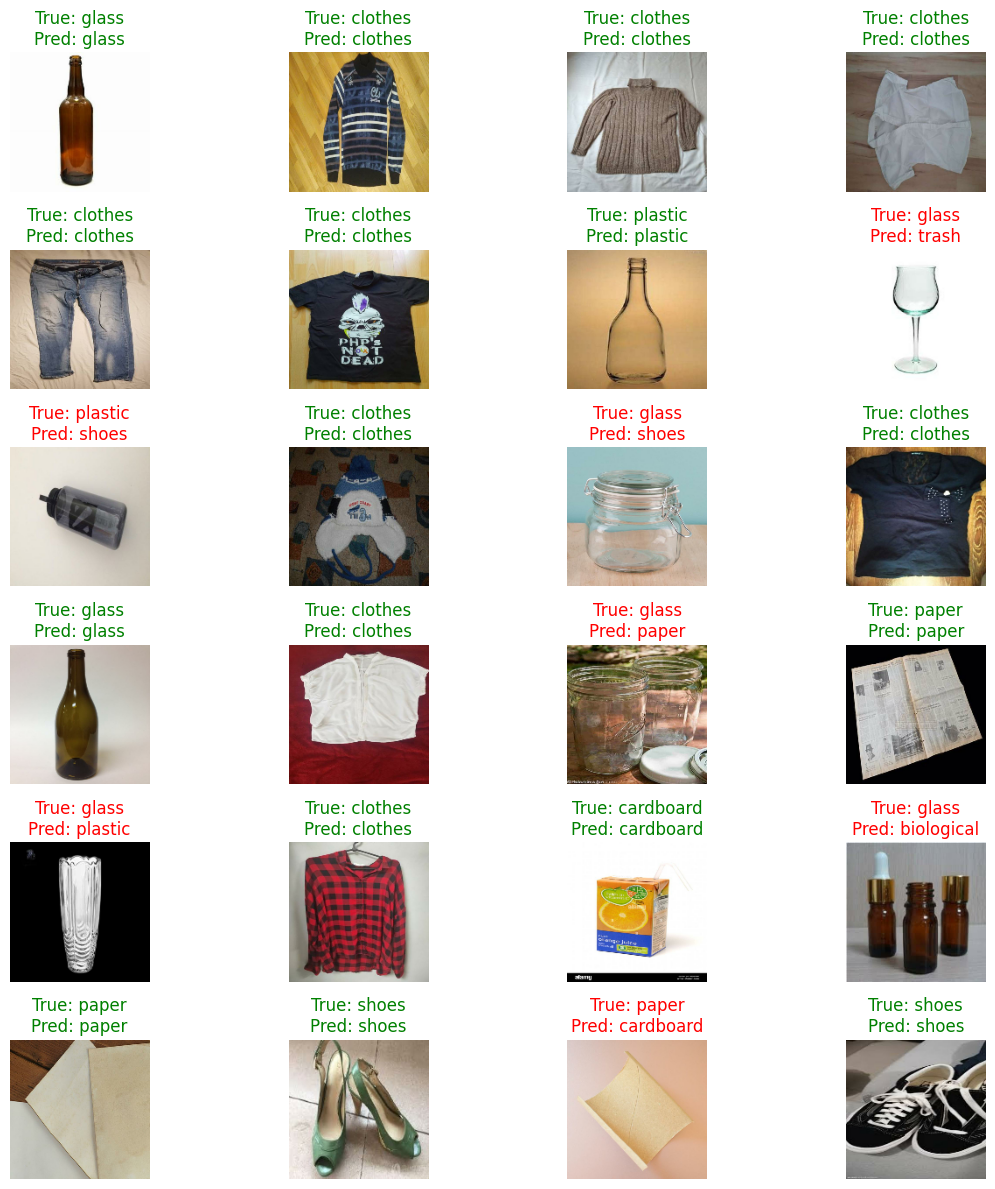

In [96]:
# Evaluate on test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Visualize some predictions
import numpy as np

# Get class names from your dataset
class_names = train_dataset.class_names
print("Classes:", class_names)

# Function to show predictions for a batch of images
plt.figure(figsize=(12, 12))
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)
    pred_classes = np.argmax(predictions, axis=1)
    
    for i in range(24):
        plt.subplot(6, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        correct = labels[i] == pred_classes[i]
        color = "green" if correct else "red"
        
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[pred_classes[i]]}", 
                 color=color)
        plt.axis("off")
plt.tight_layout()
plt.show()